<img src="surfline.png" alt="Logo" width="200" align="left">

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D
import requests
import json
from datetime import timedelta
import datetime
from windrose import WindroseAxes


## Preprocessing

In [65]:
# read in the observations all_data from oahu_all.dat
oahu = pd.read_csv('oahu_all.dat', sep='\s+', header=None, names=["year", "month", "day", "nshor", "wshor", "almo", "dh", "winw", "wspd", "wdir", "nsd", "ssd"])
oahu['date']=pd.to_datetime(oahu[['year', 'month', 'day']])
#set the date as the index
oahu.set_index('date', inplace=True)
#drop the year, month, and day columns as we done need those anymore
oahu.drop(['year', 'month', 'day'], axis=1, inplace=True)
#drop the rows with missing values for nshore as this is the target variable
oahu.dropna(subset=['nshor'], inplace=True)

# convert from Hawaiian wave measures to normal feet!!
oahu['nshor'] = oahu['nshor'] * 2

oahu.head()


,nshor,wshor,almo,dh,winw,wspd,wdir,nsd,ssd
date,,,,,,,,,
2010-01-01,12,4,2,3,4,3,2,16,13
2010-01-02,14,4,2,2,3,2,17,14,999
2010-01-03,12,4,2,2,2,4,11,15,999
2010-01-04,12,3,2,2,2,4,11,14,999
2010-01-05,36,6,2,2,2,4,11,14,999


In [66]:
#lets do the same for the buoy all_data so and get it cleaned up
#read in the buoy all_data from buoy_all.dat
buoy_data=pd.read_csv('buoy_all.dat', sep='\s+', header=1, names=["YYYY", "MM", "DD", "hh", "mm", "WDIR", "WSPD", "GST",  "WVHT", "DPD", "APD", "MWD", "PRES", "ATMP", "WTMP", "DEWP",  "VIS", "TIDE"])  
#drop out any missing values in the year/month/day/hour/minute columns
buoy_data.dropna(subset=['YYYY', 'MM', 'DD', 'hh', 'mm'], inplace=True)

# remove any rows where the YYYY column is not a 4 digit number
buoy_data = buoy_data[buoy_data['YYYY'].astype(str).str.match(r'^20[0-9][0-9]$')]

# combine the date components into a single column
buoy_data['date'] = pd.to_datetime(buoy_data.YYYY.astype(str)+"-"+buoy_data.MM.astype(str)+"-"+buoy_data.DD.astype(str)+" "+buoy_data.hh.astype(str)+":"+buoy_data.mm.astype(str)+":00")

#convert the date column to datetime and make it the index
buoy_data['date']=pd.to_datetime(buoy_data['date'])

# drop the year, month, day columns now as we dont need them anymore
buoy_data.drop(['YYYY', 'MM', 'DD', 'hh','mm'], axis=1, inplace=True)

# set the date column as the index
buoy_data.set_index('date', inplace=True)

#adjust the timezone to match the observations all_data
buoy_data.index = buoy_data.index + timedelta(hours=-10)

# convert all columns to numeric
buoy_data = buoy_data.apply(pd.to_numeric, errors='coerce')

# group the all_data by day and take the max value for each day
# mask the non-highest values out
idx = buoy_data.groupby(
            ([buoy_data.index.year, buoy_data.index.month, buoy_data.index.day])
            )['WVHT'].transform(max) == buoy_data['WVHT']

# apply the mask
buoy_data = buoy_data[idx]

#resample the all_data to daily all_data
buoy_data = buoy_data.resample('d').max()

# replace any 99.0 or 999.0 values with NaN
buoy_data.replace(9999.0, np.nan, inplace=True)
buoy_data.replace(999.0, np.nan, inplace=True)
buoy_data.replace(99.0, np.nan, inplace=True)

# drop any columns where all values are missing
buoy_data.dropna(axis=1, how='all', inplace=True)


# lets convert the wave height to feet to match the observations all_data
buoy_data['WVHT'] = buoy_data['WVHT'] * 3.28084

buoy_data.head()

,WVHT,DPD,APD,MWD,WTMP
date,,,,,
2009-12-31,9.284777,13.33,9.89,319.0,24.7
2010-01-01,7.808399,11.76,8.21,328.0,24.7
2010-01-02,6.430446,16.67,10.52,314.0,24.9
2010-01-03,6.266404,13.33,7.49,321.0,24.6
2010-01-04,7.152231,11.11,7.17,319.0,24.8


In [67]:
# lets merge all the data together on the date
all_data = pd.merge(buoy_data,oahu, how='outer', left_index=True, right_index=True)

# drop rows where there is missing nshor or WVHT data
all_data.dropna(subset=['nshor', 'WVHT'], inplace=True)
# all_data.dropna(subset=['nshor'], inplace=True)

all_data.head()

,WVHT,DPD,APD,MWD,WTMP,nshor,wshor,almo,dh,winw,wspd,wdir,nsd,ssd
date,,,,,,,,,,,,,,
2010-01-01,7.808399,11.76,8.21,328.0,24.7,12.0,4.0,2.0,3.0,4.0,3.0,2.0,16.0,13
2010-01-02,6.430446,16.67,10.52,314.0,24.9,14.0,4.0,2.0,2.0,3.0,2.0,17.0,14.0,999
2010-01-03,6.266404,13.33,7.49,321.0,24.6,12.0,4.0,2.0,2.0,2.0,4.0,11.0,15.0,999
2010-01-04,7.152231,11.11,7.17,319.0,24.8,12.0,3.0,2.0,2.0,2.0,4.0,11.0,14.0,999
2010-01-05,14.468504,14.29,11.51,315.0,24.8,36.0,6.0,2.0,2.0,2.0,4.0,11.0,14.0,999


In [68]:
# it looks like all the nshore values are whole numbers so lets just check that.  This makes sense - we dont go to the beach and say its 3.5 foot!
all_data['nshor'].apply(lambda x: x.is_integer()).unique()
# Lets round the buoy data to the nearest whole number
all_data['WVHT']=all_data['WVHT'].round()

The wave buoy is situated approximately 6Km NW from Waimea therefore any swell directions so anything with dirrection between 45 and 225 would not reach the bay so can be ignored from the analysis


<img src="WiameaBuoy.png" alt="buoy Description"  width="400" height="300">



The tide data would be useful here as this can have a big affect on the nearshore wave heights observed.  Sadly as the time of the nearshore observation is not available we cannot know this. However, if we knew the time that the observation was made we coudl obtain the tide hight from the following API and add this to the model training.

this is the station for Halleiwa just around the corner from Waimea Bay.
'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20100801&end_date=20100831&station=1612668&product=predictions&datum=MLLW&time_zone=lst_ldt&interval=hilo&units=english&application=DataAPI_Sample&format=json'


## Exploritory Data Analysis

60.0


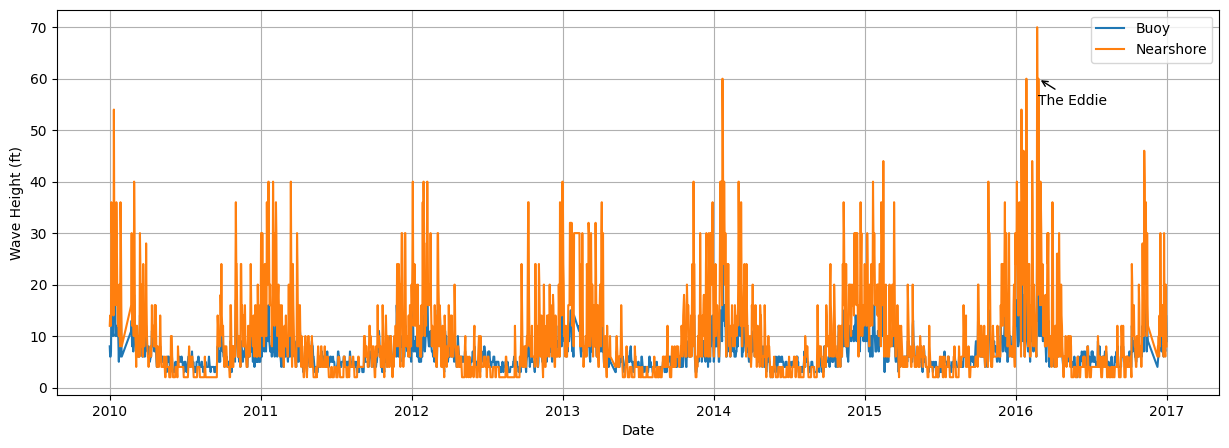

In [69]:
# lets plot the buoy wave height and nearshore wave height time series
plt.figure(figsize=(15,5))
plt.plot(all_data.index, all_data['WVHT'], label='Buoy')
plt.plot(all_data.index, all_data['nshor'], label='Nearshore')
plt.xlabel('Date')
plt.ylabel('Wave Height (ft)')
plt.grid(True)
#annote the data point on 2016-02-25 with the highest wave height
target_date = datetime.datetime.strptime('2016-02-25', '%Y-%m-%d')
# Retrieve the wave height value for the target date
target_value = all_data.loc[target_date]['nshor']
print(target_value)
plt.annotate('The Eddie', xy=(target_date, target_value), xytext=(target_date, target_value-5 ),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.legend()


<div style="display: flex; align-items: top;">
    <div style="flex: 1;">
        <img src="Hawaii.jpg" alt="Island view" width="800px">
    </div>
    <div style="flex: 1; margin-left: 20px;">
        <p>The plot above clearly shows the periodicity of the winter/summer cycles with larger waves in the winter</p>
        <p>Although diffracted waves from these swell dirrections would be noticed int he bay, for the purposes of training the models, it might be a good idea to remove data where the buoy data is registering dirrections between 45-225 degrees as these would be prodominantly blocked by the Island</p>
    </div>
</div>



In [70]:
# remove data where the MWD is between 45 and 225 degrees
all_data=all_data[(all_data['MWD'] < 45) | (all_data['MWD'] > 225)]

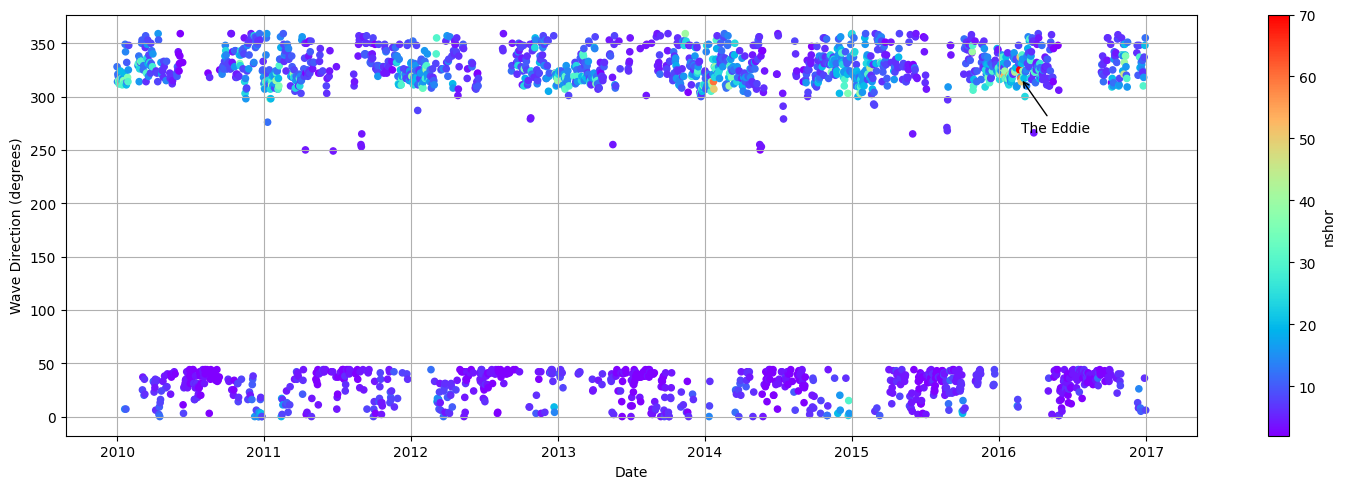

In [71]:

all_data['date'] = all_data.index
target_value = all_data.loc[target_date]['MWD']
all_data.plot(kind='scatter',x='date', y='MWD', c='nshor', cmap='rainbow', colorbar=True, figsize=(15,5), sharex=False, grid=True)
plt.annotate('The Eddie', xy=(target_date, target_value), xytext=(target_date, target_value-50 ),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.xlabel('Date')
plt.ylabel('Wave Direction (degrees)')
plt.tight_layout()


Text(0.5, 0, 'Nearshore wave height (ft)')

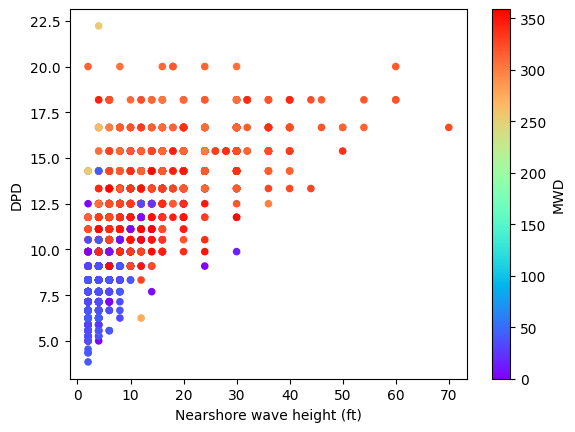

In [147]:
all_data.plot(kind='scatter',x='nshor', y='DPD', c='MWD', cmap='rainbow', colorbar=True, sharex=False)
plt.xlabel('Nearshore wave height (ft)')



Text(-0.1, 0.5, 'Wave Height (WVHT)')

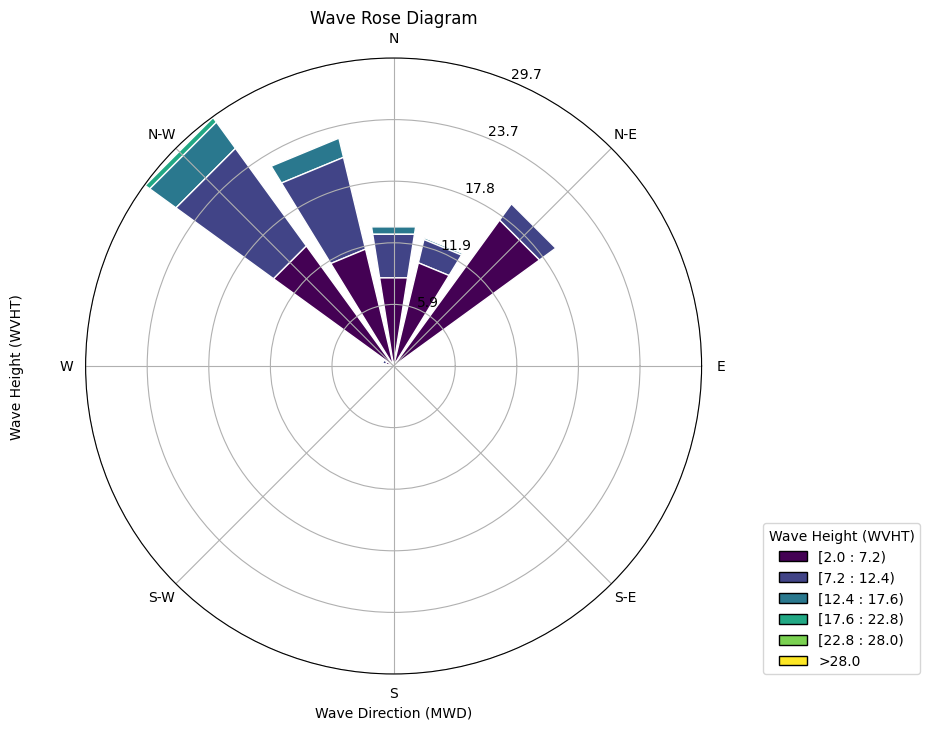

In [74]:
#plot a wave rose diagram for the wave direction
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection="windrose"))
ax.set_facecolor('none')

# Plot the wave rose diagram
ax.bar(all_data['MWD'], all_data['WVHT'], normed=True, opening=0.8, edgecolor='white')

# Set the legend
ax.legend(title='Wave Height (WVHT)', loc=(1.1, 0))

# Set the title and labels
ax.set_title('Wave Rose Diagram')
ax.set_xlabel('Wave Direction (MWD)')
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.set_ylabel('Wave Height (WVHT)')

So it looks like the swell from the West is completely blocked by the headland and it does not get into the bay! Lets check that out!

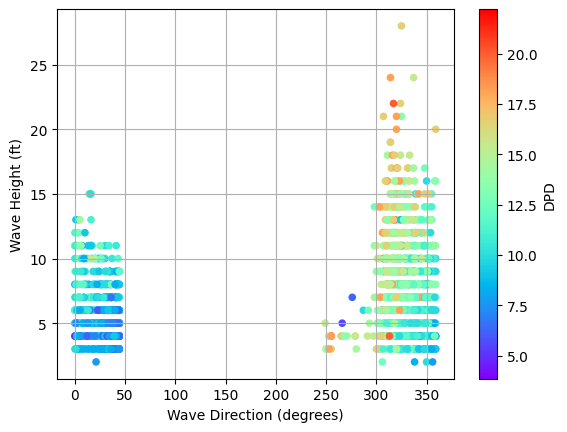

In [75]:
#lets look only at swell between 180 degrees and 300 degrees
all_data.plot(kind='scatter',x='MWD', y='WVHT', c='DPD', cmap='rainbow', colorbar=True, sharex=False)
plt.xlabel('Wave Direction (degrees)')
plt.ylabel('Wave Height (ft)')
plt.grid(True)


So this plot confirms the findings of the wave rose that waves with an incident dirrection between 180-300 degrees are being blocked by the Island and only allowing smaller waves to diffract around to the bay.  There seems to be a mixture of periods in the cluster of small waves between 250 and 300 degrees suggesting that it is not period dependent.

(-3.5, 73.5, -1.75, 75.25)

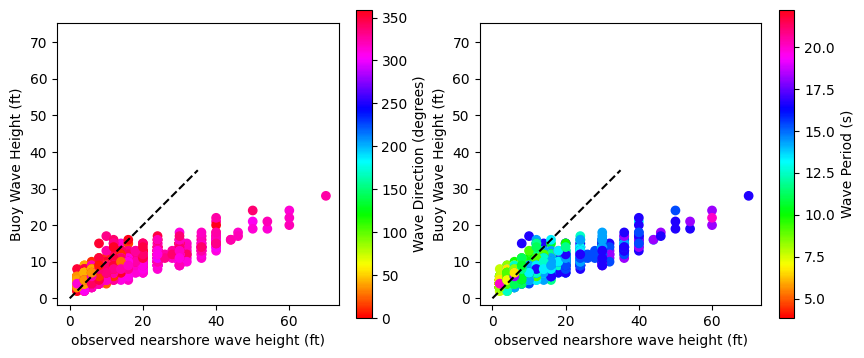

In [146]:
%matplotlib inline
plt.figure(figsize=(10, 4)) 
plt.subplot(1,2,1)
plt.scatter(all_data['nshor'],all_data['WVHT'], c=all_data['MWD'], cmap='hsv')
plt.plot([0,35],[0,35],'k--')
plt.ylabel('Buoy Wave Height (ft)')
plt.xlabel('observed nearshore wave height (ft)')
plt.colorbar(label='Wave Direction (degrees)')
plt.axis('square')

plt.subplot(1,2,2)
plt.scatter(all_data['nshor'],all_data['WVHT'], c=all_data['DPD'], cmap='hsv')
plt.plot([0,35],[0,35],'k--')
plt.ylabel('Buoy Wave Height (ft)')
plt.xlabel('observed nearshore wave height (ft)')
plt.colorbar(label='Wave Period (s)')
plt.axis('square')

It doenst look obvious that its particular wave directions or periods that results in wild differences in the nearshore wave height and the buoy all_data

In [77]:
#calculate the correlation coefficient
all_data['WVHT'].corr(all_data['nshor'])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.8707319081848205

## Predictive Models

Mean Squared Error: 46.841628959276015
R-squared value: -3.5939340100095825


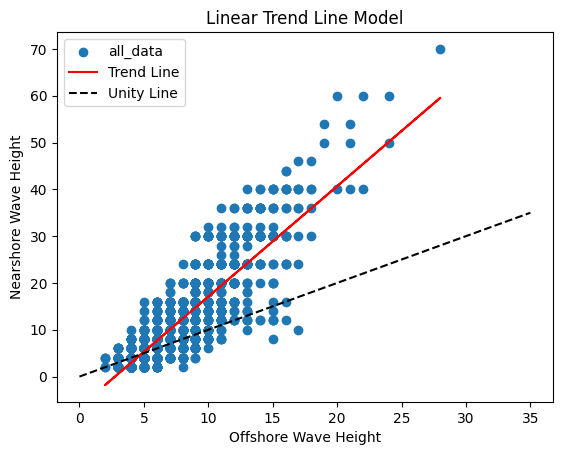

In [133]:
#lets make a linear regression model using only the model buoy all_data as a comparitor to see if we can improve it
X = all_data['WVHT']
y = all_data['nshor']

# Fit a linear regression line
coefficients = np.polyfit(X, y, deg=1)
slope = coefficients[0]
intercept = coefficients[1]

# Generate the trend line
trend_line = slope * X + intercept

# Plot the all_data points and trend line
plt.scatter(X, y, label='all_data')
plt.plot(X, trend_line, color='red', label='Trend Line')
plt.plot([0,35],[0,35],'k--', label='Unity Line')
plt.xlabel('Offshore Wave Height')
plt.ylabel('Nearshore Wave Height')
plt.title('Linear Trend Line Model')
plt.legend()

# Evaluate the model
mse = mean_squared_error(X, y)
print('Mean Squared Error:', mse)
r_squared = r2_score(X, y)
print("R-squared value:", r_squared)


In [131]:
# linear regression model of the wave height nearshore from the buoy wave height, direction and mean period

# Define the input features (X) and the target variable (y)
X = all_data[['WVHT', 'DPD', 'MWD']] 
y = all_data['nshor']
#split the all_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training all_data
model.fit(X_train, y_train)

# Make predictions on the test all_data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)
r_squared = r2_score(y_test, y_pred)
print("R-squared value:", r_squared)




Mean Squared Error: 12.109627345109024
R-squared value: 0.8260734406759639


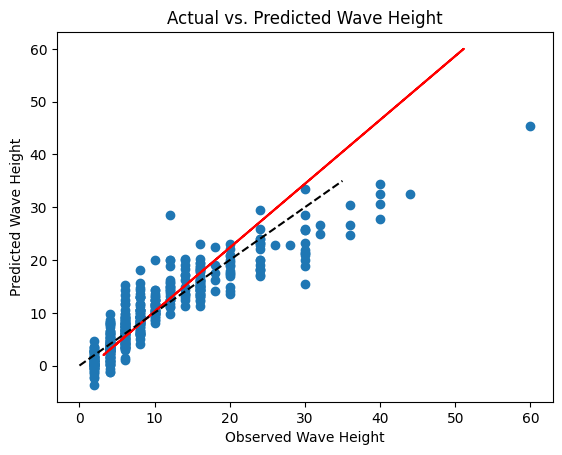

In [134]:
# Plotting the predicted values against the actual values
coefficients = np.polyfit(y_test, y_pred, deg=1)
# plot out the trend of the predicted vs. actual values
plt.plot(coefficients[0]*y_test+coefficients[1], y_test, color='red', label='Trend Line')

plt.scatter(y_test, y_pred)
plt.xlabel('Observed Wave Height')
plt.ylabel('Predicted Wave Height')
plt.title('Actual vs. Predicted Wave Height')
plt.plot([0,35],[0,35],'k--', label='Unity Line')


In [135]:
# lets see if a decision tree model performs better
# Create and train the Decision Tree model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r_squared = r2_score(y_test, y_pred)
print("R-squared value:", r_squared)

Mean Squared Error: 19.17755656108597
R-squared value: 0.7245591186372096


In [138]:
# lets see if a random forest approach does any better
# Create and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r_squared = r2_score(y_test, y_pred)
print("R-squared value:", r_squared)

Mean Squared Error: 12.194910544858542
R-squared value: 0.8248485463767541


Text(0, 0.5, 'Predicted wave height (ft)')

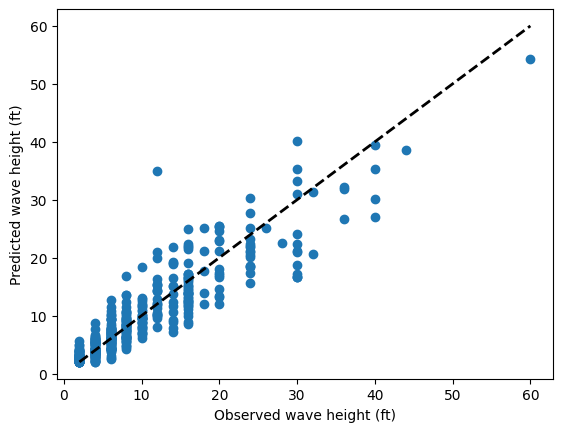

In [139]:
# Lets plot out these results as they look better!
# Plotting the results
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Plotting the diagonal line
plt.xlabel('Observed wave height (ft)')
plt.ylabel('Predicted wave height (ft)')

In [85]:
#lets see if a bit of hyperparameter tuning can improve the model
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Perform grid search cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Mean Squared Error: 9.862161320039373


In [140]:
# it has improved the model a little bit! so lets put those parameters into the model
# Create and train the Random Forest model
model = RandomForestRegressor(n_estimators=100,max_depth=10,min_samples_leaf=4,min_samples_split=10, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r_squared = r2_score(y_test, y_pred)
print("R-squared value:", r_squared)


Mean Squared Error: 9.862161320039373
R-squared value: 0.8583530494366671


In [123]:
# lets train a convolutional neural network to predict the nearshore wave height from the buoy wave height, direction and mean period

#split the all_data again in the same way as the previous model to maintain consistency - using random seed 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input features for compatibility with the CNN
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_train, axis=2)

# Build the CNN model
# Build the model
model = Sequential()
model.add(Dense(164, activation='relu', input_shape=(3,)))
model.add(Dense(164, activation='relu'))
model.add(Dense(1, activation='relu'))

# Compile and train the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=30, verbose=1)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
predictions = model.predict(X_test)

Epoch 1/50
59/59 [==============================] - 1s 3ms/step - loss: 101.2061
Epoch 2/50
59/59 [==============================] - 0s 4ms/step - loss: 34.2602
Epoch 3/50
59/59 [==============================] - 0s 2ms/step - loss: 24.7251
Epoch 4/50
59/59 [==============================] - 0s 3ms/step - loss: 20.1795
Epoch 5/50
59/59 [==============================] - 0s 2ms/step - loss: 16.5525
Epoch 6/50
59/59 [==============================] - 0s 2ms/step - loss: 14.3337
Epoch 7/50
59/59 [==============================] - 0s 922us/step - loss: 15.8064
Epoch 8/50
59/59 [==============================] - 0s 1ms/step - loss: 14.3616
Epoch 9/50
59/59 [==============================] - 0s 937us/step - loss: 14.7516
Epoch 10/50
59/59 [==============================] - 0s 968us/step - loss: 13.3495
Epoch 11/50
59/59 [==============================] - 0s 899us/step - loss: 13.6233
Epoch 12/50
59/59 [==============================] - 0s 831us/step - loss: 13.6496
Epoch 13/50
59/59 [=======

In [106]:
predictions.shape

(442, 1)

Mean Squared Error: 9.617440680561389
R-squared value: 0.8618678907779388


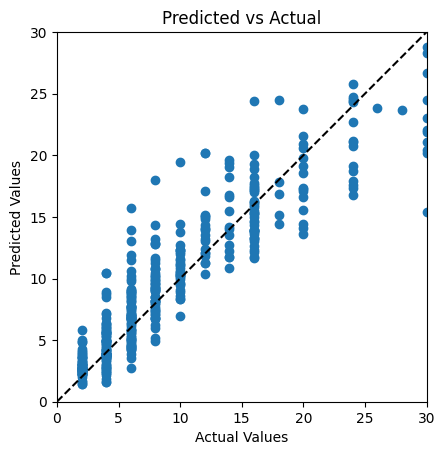

In [145]:
#lets plot out the results
# Create a scatter plot
plt.scatter(y_test, predictions)

# Add labels and title
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.title('Predicted vs Actual')
# Set the axes to be equal
plt.axis('square')
#cut the x and y axis to be the same
plt.xlim([0, 30])
plt.ylim([0, 30])   
# Add a diagonal line for reference
plt.plot([0, 30], [0, 30], 'k--')
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)
r_squared = r2_score(y_test, predictions)
print("R-squared value:", r_squared)


So it looks like predicting the surf with only wave height, wave dirrection and period is quite tricky!!